In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim
import os
from torch.utils.data import Subset, DataLoader ,Dataset
from torchvision import models
from torchvision.datasets import CIFAR10
from collections import defaultdict

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
VGG_net = models.vgg19(pretrained=True)
original_fc_layers = VGG_net.classifier
feature_extractor = VGG_net.features
print("Original VGG_net_feature_extractor:")
print(feature_extractor)
print("\nOriginal Fully Connected Layers:")
print(original_fc_layers)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 152MB/s]


Original VGG_net_feature_extractor:
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17

100%|██████████| 170498071/170498071 [00:01<00:00, 96176757.45it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/10], Loss: 0.0027, Accuracy: 88.46%
Epoch [2/10], Loss: 0.0018, Accuracy: 92.97%
Epoch [3/10], Loss: 0.0017, Accuracy: 93.32%
Epoch [4/10], Loss: 0.0016, Accuracy: 94.08%
Epoch [5/10], Loss: 0.0016, Accuracy: 93.81%
Epoch [6/10], Loss: 0.0015, Accuracy: 93.94%
Epoch [7/10], Loss: 0.0015, Accuracy: 94.00%
Epoch [8/10], Loss: 0.0015, Accuracy: 94.36%
Epoch [9/10], Loss: 0.0015, Accuracy: 94.17%
Epoch [10/10], Loss: 0.0015, Accuracy: 94.22%
Accuracy of the model on the test images: 95.70%


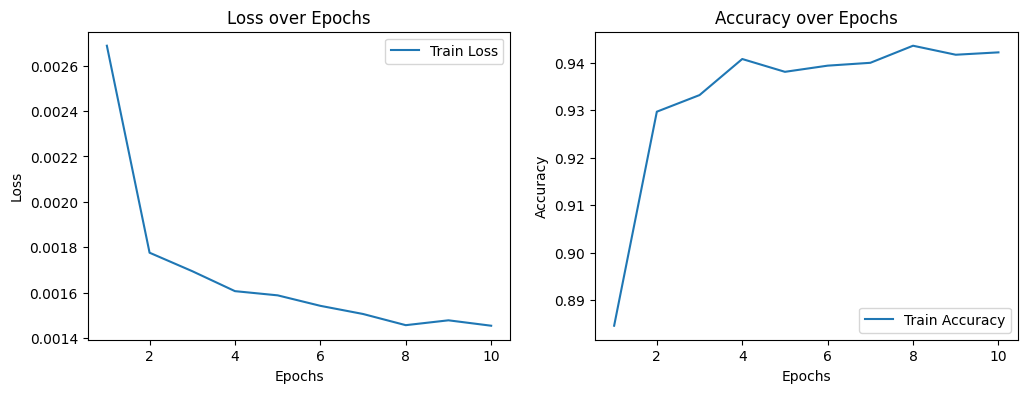

In [4]:
num_epochs = 10
batch_size = 100
device = "cuda" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()])

train_dataset = CIFAR10(root= './data', train = True, download =True, transform = transform)
test_dataset = CIFAR10(root= './data', train = False, download =True, transform = transform)

target_class = [0,1]
train_indices = []
for i, label in enumerate(train_dataset.targets):
    if label in target_class:
        train_indices.append(i)

test_indices = []
for i, label in enumerate(test_dataset.targets):
    if label in target_class:
        test_indices.append(i)

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_subset, batch_size = batch_size, shuffle = True)

VGG_net = models.vgg19(pretrained=True)
for param in VGG_net.parameters():
    param.requires_grad = False

number_features = VGG_net.classifier[6].in_features

features = list(VGG_net.classifier.children())[:-1]
features.extend([torch.nn.Linear(number_features, 2)])
VGG_net.classifier = torch.nn.Sequential(*features)
VGG_net = VGG_net.to(device)

optimizer = torch.optim.SGD(VGG_net.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
train_accuracy = []
train_loss = []
for epoch in range(num_epochs):
    VGG_net.train()
    epoch_train_accuracy = 0.0
    epoch_train_loss = 0.0
    for i, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = VGG_net(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        epoch_train_accuracy += (predicted == labels).sum().item()
    epoch_train_loss /= len(train_indices)
    epoch_train_accuracy /= len(train_indices)
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_train_loss:.4f}, Accuracy: {100 * epoch_train_accuracy:.2f}%')


VGG_net.eval()
test_accuracy = 0.0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = VGG_net(imgs)
        _, predicted = torch.max(outputs.data, 1)
        test_accuracy += (predicted == labels).sum().item()

test_accuracy /= len(test_indices)
print(f'Accuracy of the model on the test images: {100 * test_accuracy:.2f}%')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracy, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, img ,transform=None):
#         self.img = img
#         self.transform = transform
#     def __len__(self):
#         return len(self.img)
#     def __getitem__(self, idx):
#      anchor_img, anchor_label = self.img[idx]
#      positive_indices = []
#      for i, (_, label) in enumerate(self.img):
#         if label == anchor_label and i != idx:
#             positive_indices.append(i)
#      negative_indices = []
#      for i, (_, label) in enumerate(self.img):
#         if label != anchor_label:
#             negative_indices.append(i)
#      positive_idx = random.choice(positive_indices)
#      negative_idx = random.choice(negative_indices)
#      positive_img, _ = self.img[positive_idx]
#      negative_img, _ = self.img[negative_idx]
#      return anchor_img, positive_img, negative_img, anchor_label

Files already downloaded and verified


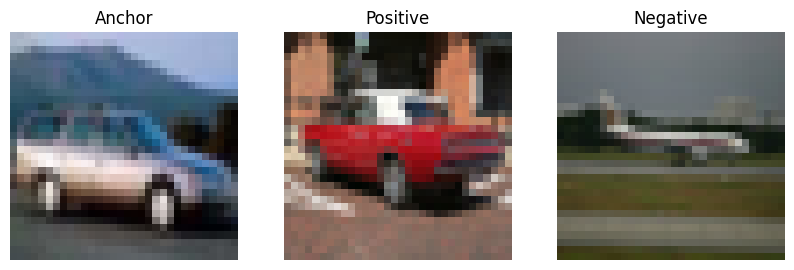

In [ ]:
# transform = transforms.Compose([transforms.ToTensor()])
# train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
# target_classes = [0, 1]
# train_indices = [i for i, label in enumerate(train_dataset.targets) if label in target_classes]
# train_subset = Subset(train_dataset, train_indices)
# triplet_dataset = CustomDataset(train_subset, transform)

# idx_to_display = 0
# anchor_img, positive_img, negative_img, label = triplet_dataset[idx_to_display]

# anchor_img = anchor_img.permute(1, 2, 0).numpy()
# positive_img = positive_img.permute(1, 2, 0).numpy()
# negative_img = negative_img.permute(1, 2, 0).numpy()

# fig, axes = plt.subplots(1, 3, figsize=(10, 4))
# axes[0].imshow(anchor_img)
# axes[0].set_title('Anchor')
# axes[0].axis('off')

# axes[1].imshow(positive_img)
# axes[1].set_title('Positive')
# axes[1].axis('off')

# axes[2].imshow(negative_img)
# axes[2].set_title('Negative')
# axes[2].axis('off')

# plt.show()

In [3]:
# با استفاده از لیبل  تصویر انچور یک تصویر دیگر با همین لیبل انتخاب می کنم و آن را به عنوان تصویر مثبت
# در نظر می گیرم .
# برای تولید تصویر منفی نیز تصاویری که لیبل آن ها متفاوت از لیبل انچور است انخاب می شوند و
# با انتخاب یکی از آن ها تصویر منفی تولید میشود
class CustomDataset(Dataset):
    def __init__(self, img, transform=None):
        self.img = img
        self.transform = transform
        self.label_to_indices = defaultdict(list)
        for i, (_, label) in enumerate(img):
            self.label_to_indices[label].append(i)
    def __len__(self):
        return len(self.img)
    def __getitem__(self, idx):
        anchor_img, anchor_label = self.img[idx]

        positive_indices = self.label_to_indices[anchor_label].copy()
        positive_indices.remove(idx)
        positive_idx = random.choice(positive_indices)
        positive_img, _ = self.img[positive_idx]

        negative_label = 1 - anchor_label
        negative_idx = random.choice(self.label_to_indices[negative_label])
        negative_img, _ = self.img[negative_idx]
        return anchor_img, positive_img, negative_img, anchor_label

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CIFAR10(root= './data', train = True, download =True, transform = transform)
test_dataset = CIFAR10(root= './data', train = False, download =True, transform = transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 72837527.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
target_class = [0,1]
train_indices = []
for i, label in enumerate(train_dataset.targets):
    if label in target_class:
        train_indices.append(i)
train_subset = Subset(train_dataset, train_indices)
train_loader = DataLoader(train_subset, batch_size = 100, shuffle = True)
custom_dataset_train  = CustomDataset(train_subset, transform)
train_custom_loader = DataLoader(custom_dataset_train, batch_size=100, shuffle=True)

test_indices = []
for i, label in enumerate(test_dataset.targets):
  if label in target_class:
    test_indices.append(i)

test_subset = Subset(test_dataset, test_indices)
test_loader = DataLoader(test_subset, batch_size = 100, shuffle = True)
custom_dataset_test  = CustomDataset(test_subset, transform)
test_custom_loader = DataLoader(custom_dataset_test, batch_size=100, shuffle=True)
# print(len(train_subset))
# print(len(custom_dataset))
# print(len(train_custom_loader))
# # print(custom_dataset[10001])

# for i, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(train_custom_loader):
#     if i < 2:  # Display only the first two triplets
#         anchor_img = TF.to_pil_image(anchor_img[0])
#         positive_img = TF.to_pil_image(positive_img[0])
#         negative_img = TF.to_pil_image(negative_img[0])

#         plt.figure(figsize=(9, 3))
#         plt.subplot(1, 3, 1)
#         plt.imshow(anchor_img)
#         plt.title(f"Anchor (Label: {anchor_label[0].item()})")

#         plt.subplot(1, 3, 2)
#         plt.imshow(positive_img)
#         plt.title("Positive")

#         plt.subplot(1, 3, 3)
#         plt.imshow(negative_img)
#         plt.title("Negative")

#         plt.show()

In [10]:
for batch_idx, batch in enumerate(train_custom_loader):
    for element_idx, element in enumerate(batch):
        print(f"Size of element {element_idx} in the first batch:", element.size())
    break

Size of element 0 in the first batch: torch.Size([100, 3, 32, 32])
Size of element 1 in the first batch: torch.Size([100, 3, 32, 32])
Size of element 2 in the first batch: torch.Size([100, 3, 32, 32])
Size of element 3 in the first batch: torch.Size([100])


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
VGG_net = torchvision.models.vgg19(pretrained = True)

number_features = VGG_net.classifier[6].in_features
features = list(VGG_net.classifier.children())[:-1]
features.extend([torch.nn.Linear(number_features,2)])
VGG_net.classifier = torch.nn.Sequential(*features)

VGG_net = VGG_net.to(device)

print(VGG_net)
print(VGG_net.features)
print(VGG_net.classifier)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 84.5MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [7]:
# در این قسمت کلاس تریپلت لاس را تعریف کردم . برای بهتر شدن همگرایی لاس از معیار
# cosine similarity
# استفاده کردم
class TripletLoss(nn.Module):
    def __init__(self, margin=2):
        super(TripletLoss, self).__init__()
        self.margin = margin
    def forward(self, anchor, positive, negative):
        # Cosine similarity
        cos_sim_pos = F.cosine_similarity(anchor, positive)
        cos_sim_neg = F.cosine_similarity(anchor, negative)
        loss = torch.relu(cos_sim_neg - cos_sim_pos + self.margin)
        return torch.mean(loss)


# # Triplet loss function
# class TripletLoss(nn.Module):
#     def __init__(self, margin=0.001):
#         super(TripletLoss, self).__init__()
#         self.margin = margin

#     def forward(self, anchor, positive, negative):
#         distance_positive = torch.sum((anchor - positive)**2, dim=1)
#         distance_negative = torch.sum((anchor - negative)**2, dim=1)
#         loss = torch.relu(distance_positive - distance_negative + self.margin)
#         return torch.mean(loss)

Epoch [1/5], Batch [1/100], Triplet Loss: 1.9128
Epoch [1/5], Batch [51/100], Triplet Loss: 1.2439
Epoch [1/5], Average Triplet Loss: 1.3786
Epoch [2/5], Batch [1/100], Triplet Loss: 1.1303
Epoch [2/5], Batch [51/100], Triplet Loss: 1.0571
Epoch [2/5], Average Triplet Loss: 1.0901
Epoch [3/5], Batch [1/100], Triplet Loss: 1.0614
Epoch [3/5], Batch [51/100], Triplet Loss: 1.0924
Epoch [3/5], Average Triplet Loss: 1.0718
Epoch [4/5], Batch [1/100], Triplet Loss: 1.0337
Epoch [4/5], Batch [51/100], Triplet Loss: 1.0256
Epoch [4/5], Average Triplet Loss: 1.0386
Epoch [5/5], Batch [1/100], Triplet Loss: 1.0254
Epoch [5/5], Batch [51/100], Triplet Loss: 1.0459
Epoch [5/5], Average Triplet Loss: 1.0309


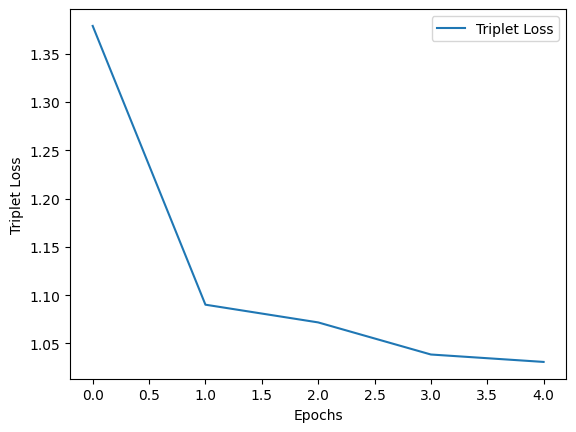

Epoch [1/5], Loss: 0.1884, Accuracy: 98.87%
Epoch [2/5], Loss: 0.0369, Accuracy: 99.31%
Epoch [3/5], Loss: 0.0343, Accuracy: 99.36%
Epoch [4/5], Loss: 0.0303, Accuracy: 99.36%
Epoch [5/5], Loss: 0.0301, Accuracy: 99.36%


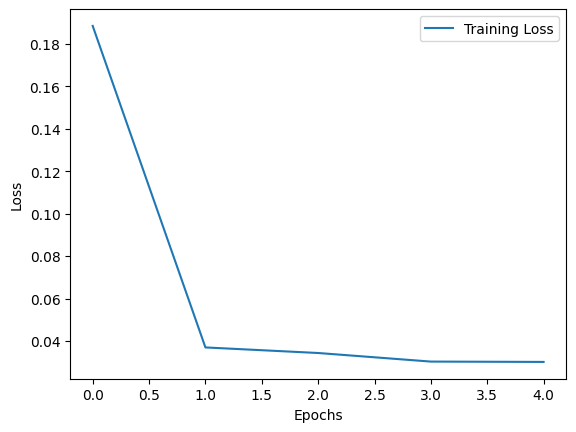

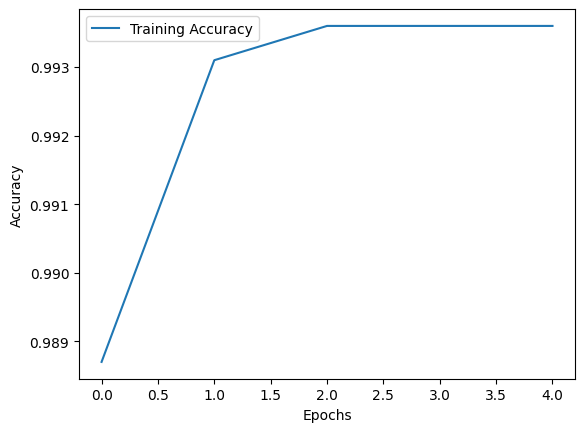

Accuracy of the model on the test images: 98.20%


In [8]:
triplet_optimizer = optim.SGD(VGG_net.features.parameters(), lr=0.001, momentum=0.9)
triplet_criterion = TripletLoss()
triplet_losses = []

# Training loop for the feature extractor
num_triplet_epochs = 5
for epoch in range(num_triplet_epochs):
    VGG_net.features.train()
    total_triplet_loss = 0
    num_batches = len(train_custom_loader)
    for i, (anchor, positive, negative, label) in enumerate(train_custom_loader):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        triplet_optimizer.zero_grad()
        anchor_output = VGG_net.features(anchor)
        positive_output = VGG_net.features(positive)
        negative_output = VGG_net.features(negative)
        triplet_loss = triplet_criterion(anchor_output, positive_output, negative_output)
        triplet_loss.backward()
        triplet_optimizer.step()

        total_triplet_loss += triplet_loss.item()
        # print(total_triplet_loss)
        if i % 50 == 0:
            print(f"Epoch [{epoch + 1}/{num_triplet_epochs}], Batch [{i + 1}/{num_batches}], Triplet Loss: {triplet_loss.item():.4f}")

    average_triplet_loss = total_triplet_loss / num_batches
    triplet_losses.append(average_triplet_loss)
    print(f"Epoch [{epoch + 1}/{num_triplet_epochs}], Average Triplet Loss: {average_triplet_loss:.4f}")

plt.plot(triplet_losses, label='Triplet Loss')
plt.xlabel('Epochs')
plt.ylabel('Triplet Loss')
plt.legend()
plt.show()
# Freeze the feature extractor
for param in VGG_net.features.parameters():
    param.requires_grad = False

# Set up the optimizer and cross-entropy loss criterion for the fully connected layer
fc_optimizer = optim.SGD(VGG_net.parameters(), lr=0.001, momentum=0.9)
fc_criterion = nn.CrossEntropyLoss()

fc_losses = []
fc_accuracies = []
# Training loop for the fully connected layer
num_fc_epochs = 5
for epoch in range(num_fc_epochs):
    VGG_net.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        fc_optimizer.zero_grad()
        outputs = VGG_net(imgs)
        fc_loss = fc_criterion(outputs, labels)
        fc_loss.backward()
        fc_optimizer.step()
        running_loss += fc_loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_samples
    fc_losses.append(avg_loss)
    fc_accuracies.append(accuracy)
    print(f'Epoch [{epoch + 1}/{num_fc_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
plt.plot(fc_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(fc_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Evaluation on the test set
VGG_net.eval()
test_accuracy_fc = 0.0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = VGG_net(imgs)
        _, predicted = torch.max(outputs.data, 1)
        test_accuracy_fc += (predicted == labels).sum().item()

test_accuracy_fc /= len(test_indices)
print(f'Accuracy of the model on the test images: {100 * test_accuracy_fc:.2f}%')

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
CHECKPOINT_FOLDER = 'deepHW3/Q1/checkpoints'
checkpoint_folder_path = os.path.join('/content/drive/My Drive', CHECKPOINT_FOLDER)
os.makedirs(checkpoint_folder_path, exist_ok=True)

In [14]:
triplet_checkpoint_path = os.path.join(checkpoint_folder_path, "triplet_model_checkpoint.pth")
torch.save({
    'epoch': num_triplet_epochs,
    'model_state_dict': VGG_net.state_dict(),
    'triplet_optimizer_state_dict': triplet_optimizer.state_dict(),
    'triplet_loss': triplet_losses,
}, triplet_checkpoint_path)


In [15]:
fc_checkpoint_path = os.path.join(checkpoint_folder_path, "fc_model_checkpoint.pth")
torch.save({
    'epoch': num_fc_epochs,
    'model_state_dict': VGG_net.state_dict(),
    'fc_optimizer_state_dict': fc_optimizer.state_dict(),
    'fc_loss': fc_losses,
    'fc_accuracy': fc_accuracies,
}, fc_checkpoint_path)

In [ ]:
triplet_checkpoint_path = os.path.join(checkpoint_folder_path, "triplet_model_checkpoint.pth")
triplet_checkpoint = torch.load(triplet_checkpoint_path)

VGG_net.load_state_dict(triplet_checkpoint['model_state_dict'])
triplet_optimizer.load_state_dict(triplet_checkpoint['triplet_optimizer_state_dict'])
triplet_losses = triplet_checkpoint['triplet_loss']

In [ ]:
fc_checkpoint_path = os.path.join(checkpoint_folder_path, "fc_model_checkpoint.pth")
fc_checkpoint = torch.load(fc_checkpoint_path)
VGG_net.load_state_dict(fc_checkpoint['model_state_dict'])
fc_optimizer.load_state_dict(fc_checkpoint['fc_optimizer_state_dict'])
fc_losses = fc_checkpoint['fc_loss']
fc_accuracies = fc_checkpoint['fc_accuracy']

Epoch [1/5], Batch [1/100], Total Loss: 1.6748
Epoch [1/5], Batch [51/100], Total Loss: 0.1727
Epoch [1/5], Average Total Loss: 0.4796, Accuracy: 93.71%
Epoch [2/5], Batch [1/100], Total Loss: 0.0794
Epoch [2/5], Batch [51/100], Total Loss: 0.1891
Epoch [2/5], Average Total Loss: 0.1189, Accuracy: 98.46%
Epoch [3/5], Batch [1/100], Total Loss: 0.1133
Epoch [3/5], Batch [51/100], Total Loss: 0.0187
Epoch [3/5], Average Total Loss: 0.0661, Accuracy: 99.14%
Epoch [4/5], Batch [1/100], Total Loss: 0.0166
Epoch [4/5], Batch [51/100], Total Loss: 0.0063
Epoch [4/5], Average Total Loss: 0.0402, Accuracy: 99.54%
Epoch [5/5], Batch [1/100], Total Loss: 0.0070
Epoch [5/5], Batch [51/100], Total Loss: 0.0041
Epoch [5/5], Average Total Loss: 0.0247, Accuracy: 99.71%


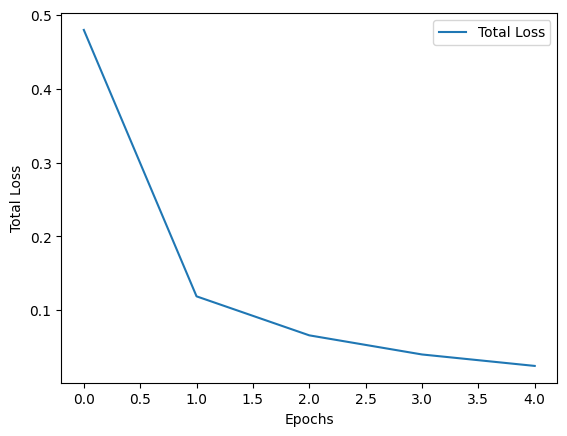

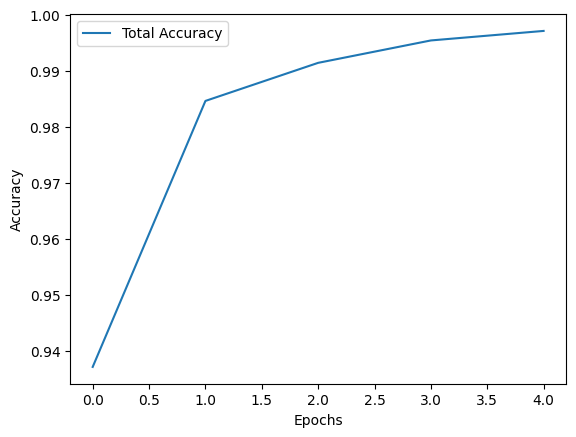

Accuracy of the model on the test images: 98.70%


In [8]:
# در این قسمت کلاس لاس کلی را تعریف کردم که مجموع تریپلپ لاس و کراس آنتروپی می باشد
class TotalLoss(nn.Module):
    def __init__(self, triplet_margin=1):
        super(TotalLoss, self).__init__()
        self.triplet_margin = triplet_margin
        self.triplet_criterion = TripletLoss(margin=triplet_margin)
        self.ce_criterion = nn.CrossEntropyLoss()

    def forward(self, anchor, positive, negative, out, labels):
        triplet_loss = self.triplet_criterion(anchor, positive, negative)
        ce_loss = self.ce_criterion(out, labels)
        total_loss = triplet_loss + ce_loss
        return total_loss


total_optimizer = optim.SGD(VGG_net.parameters(), lr=0.001, momentum=0.9)
total_criterion = TotalLoss()

total_losses = []
total_accuracies = []

num_total_epochs = 5
for epoch in range(num_total_epochs):
    VGG_net.train()
    total_loss_sum = 0
    correct_predictions_1 = 0
    total_samples = 0
    num_batches = len(train_custom_loader)
    for i, (anchor, positive, negative, labels) in enumerate(train_custom_loader):
        anchor, positive, negative, labels = anchor.to(device), positive.to(device), negative.to(device), labels.to(device)
        total_optimizer.zero_grad()
        anchor_output = VGG_net.features(anchor)
        positive_output = VGG_net.features(positive)
        negative_output = VGG_net.features(negative)
        out = VGG_net(anchor)
        total_loss = total_criterion(anchor_output, positive_output, negative_output, out, labels)
        total_loss.backward()
        total_optimizer.step()
        total_loss_sum += total_loss.item()
        _, predicted = torch.max(out, 1)
        correct_predictions_1 += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        if i % 50 == 0:
            print(f"Epoch [{epoch + 1}/{num_total_epochs}], Batch [{i + 1}/{num_batches}], Total Loss: {total_loss.item():.4f}")
    average_total_loss = total_loss_sum / num_batches
    accuracy = correct_predictions_1 / total_samples
    total_losses.append(average_total_loss)
    total_accuracies.append(accuracy)
    print(f"Epoch [{epoch + 1}/{num_total_epochs}], Average Total Loss: {average_total_loss:.4f}, Accuracy: {accuracy * 100:.2f}%")

plt.plot(total_losses, label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.legend()
plt.show()

plt.plot(total_accuracies, label='Total Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

VGG_net.eval()
test_accuracy_fc_1 = 0.0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = VGG_net(imgs)
        _, predicted = torch.max(outputs.data, 1)
        test_accuracy_fc_1 += (predicted == labels).sum().item()

test_accuracy_fc_1 /= len(test_indices)
print(f'Accuracy of the model on the test images: {100 * test_accuracy_fc_1:.2f}%')

In [12]:
total_checkpoint_path = os.path.join(checkpoint_folder_path, "total_loss_model_checkpoint.pth")
torch.save({
    'epoch': num_total_epochs,
    'model_state_dict': VGG_net.state_dict(),
    'total_optimizer_state_dict': total_optimizer.state_dict(),
    'total_loss': total_losses,
    'total_accuracy': total_accuracies,
}, total_checkpoint_path)


In [13]:
total_checkpoint_path = os.path.join(checkpoint_folder_path, "total_loss_model_checkpoint.pth")
total_checkpoint = torch.load(total_checkpoint_path)
VGG_net.load_state_dict(total_checkpoint['model_state_dict'])
total_optimizer.load_state_dict(total_checkpoint['total_optimizer_state_dict'])
total_losses = total_checkpoint['total_loss']
total_accuracies = total_checkpoint['total_accuracy']